In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Download datset

In [2]:
ROOT_DATA_DIR='FashionMNISTDir'

train_data = datasets.FashionMNIST(
    root = ROOT_DATA_DIR,
    train=True,
    download=True,
    transform = transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root =ROOT_DATA_DIR,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting FashionMNISTDir/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNISTDir/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting FashionMNISTDir/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNISTDir/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting FashionMNISTDir/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNISTDir/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting FashionMNISTDir/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNISTDir/FashionMNIST/raw



In [3]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [4]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [5]:
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3:' Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
    }

# Visualize One Example

In [6]:
def view_image(data, index, label_map):
  plt.imshow(data.data[index], cmap='gray')
  plt.title(f"data label: {label_map[data.targets[index].item()]}")
  plt.axis("off")

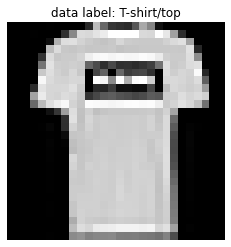

In [7]:
view_image(train_data, index=1, label_map=label_map)

# Create dataloader

In [8]:
BATCH_SIZE=64

train_data_loader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    shuffle=True
)

test_data_loader = DataLoader(
    dataset = test_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [9]:
for data, label in test_data_loader:
  print(data.shape)
  print(label.shape)
  break

torch.Size([64, 1, 28, 28])
torch.Size([64])


# Cnn Architecture

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
class CNN(nn.Module):
  def __init__(self, in_, out_):
    super(CNN, self).__init__()

    self.conv_pool_01 = nn.Sequential(
        nn.Conv2d(in_channels=in_, out_channels = 8, kernel_size=5, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_pool_02 = nn.Sequential(
        nn.Conv2d(in_channels = 8, out_channels=16, kernel_size=5, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.Flatten = nn.Flatten()
    self.FC_01 = nn.Linear(in_features=16*4*4, out_features=128)
    self.FC_02 = nn.Linear(in_features=128, out_features=64)
    self.FC_03 = nn.Linear(in_features=64, out_features = out_)

  def forward(self, x):
    x = self.conv_pool_01(x)
    x = self.conv_pool_02(x)
    x = self.Flatten(x)
    x = self.FC_01(x)
    x = self.FC_02(x)        
    x = self.FC_03(x)
    return x

In [12]:
model = CNN(1, 10)
model.to(device)

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)

#Count no of trainable parameters

In [13]:
def count_params(model):
  model_params  = {'Modules': list(), 'Parameters': list()}
  total = 0
  for name, parameters in model.named_parameters():
    if not parameters.requires_grad:
      continue
    params = parameters.numel()
    model_params['Modules'].append(name)
    model_params['Parameters'].append(params)
    total+=params
  df = pd.DataFrame(model_params)
  df = df.style.set_caption(f'Total trainable parameters: {total}')
  return df

count_params(model)

,Modules,Parameters
0,conv_pool_01.0.weight,200
1,conv_pool_01.0.bias,8
2,conv_pool_02.0.weight,3200
3,conv_pool_02.0.bias,16
4,FC_01.weight,32768
5,FC_01.bias,128
6,FC_02.weight,8192
7,FC_02.bias,64
8,FC_03.weight,640
9,FC_03.bias,10


In [14]:
next(model.parameters()).is_cuda

True

# Training

In [15]:
learning_rate = 0.001
num_epochs = 20

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [17]:
n_total_steps = len(train_data_loader)
n_total_steps

938

In [18]:
for epoch in range(num_epochs):
  with tqdm(train_data_loader) as tqdm_epoch:
    for images, labels in tqdm_epoch:
      tqdm_epoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

      images = images.to(device)
      labels = labels.to(device)

      # forwards pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      # backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      tqdm_epoch.set_postfix(loss=loss.item())

Epoch 20/20: 100%|██████████| 938/938 [00:14<00:00, 63.87it/s, loss=0.263]


In [19]:
## save trained model -
os.makedirs("CNN", exist_ok=True)
model_file = os.path.join("CNN", 'CNN_model.pth')
torch.save(model, model_file)

In [20]:
model = torch.load('CNN/CNN_model.pth')

In [21]:
pred = np.array([])
target = np.array([])

with torch.no_grad():
  for batch, data in enumerate(test_data_loader):
    image, label = data[0].to(device), data[1].to(device)
    y_pred = model(image)
    print(y_pred)
    pred = np.concatenate((pred, torch.argmax(y_pred, 1).cpu().numpy()))
    print(f'matrix: {y_pred}\n result:{pred}')
    target = np.concatenate((target, label.cpu().numpy()))

Streaming output truncated to the last 5000 lines.
          -8.8001,   6.0612,  -9.0146],
        [  8.9335,  -7.3456,   4.5702,   2.6925,   2.3727,  -7.9957,   8.0801,
         -15.1889,   0.0951, -16.9679],
        [ -4.3106, -12.6192,  -8.1753,  -2.6028,  -9.6502,   6.8095,  -5.5968,
          16.2136,   4.5091,  19.0071],
        [  1.4190,  -7.6973,  -6.4319,   5.0553,  -2.6534,  -1.3269,  -0.9867,
           3.5859,   6.9100,  -1.8166],
        [ -1.8876,  -8.8877,   1.8881,  -7.9746,  -2.7453,  20.9611,  -4.6458,
          -2.5187,  -0.0939,  -4.1678],
        [ -2.8045, -15.9736,  -0.8577,  -9.8283,  -5.3558,  23.2319,  -4.0373,
           5.9962,  -0.5553,  -3.7054],
        [ -0.1106,  -7.5914,   1.7070,   2.3786,   0.4838,  -5.4936,   4.5379,
          -0.6369,  -0.5391,  -0.5784],
        [  5.9262,  23.6211,  -1.6927,   6.2537,   4.1520,  -3.6246,   1.8324,
          -7.7578,  -4.0870, -14.8762],
        [  1.6960,  19.2372,  -4.7616,   4.3560,   2.0470,   2.3138,   1.867

In [22]:
cm = confusion_matrix(target, pred)

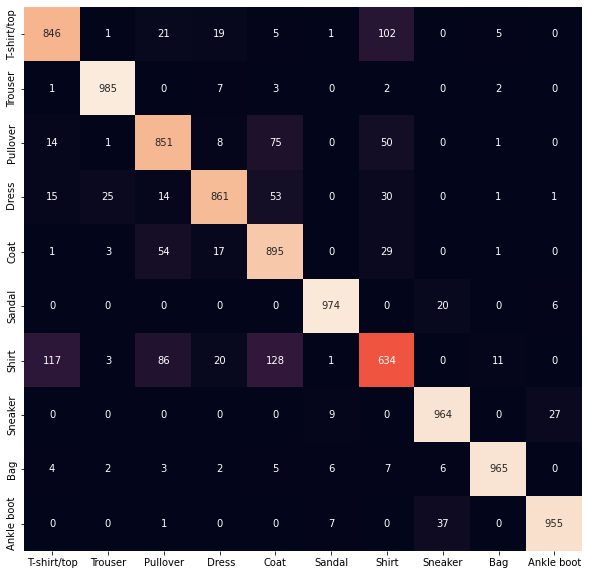

In [23]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.values(), yticklabels=label_map.values(), cbar=False)

In [24]:
data = next(iter(test_data_loader))
data

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [25]:
len(data)

2

In [26]:
images, label = data

In [29]:
images.shape

torch.Size([64, 1, 28, 28])

torch.Size([1, 28, 28])


'Sandal'

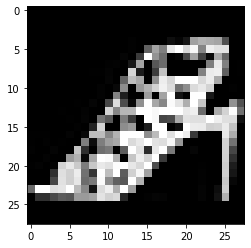

In [39]:
img = images[0]
print(img.shape)
plt.imshow(img.squeeze(), cmap='gray')
label_map[label[0].item()]

In [40]:
img.shape, img.squeeze().shape, img.unsqueeze(1).shape

(torch.Size([1, 28, 28]), torch.Size([28, 28]), torch.Size([1, 1, 28, 28]))

In [41]:
logit = model(img.unsqueeze(1).to(device))
logit

tensor([[-0.6565, -7.4199,  0.6566, -4.5392,  1.2935,  7.7079, -1.9788, -0.0421,
         -5.9201,  1.9099]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [42]:
pred_prob = F.softmax(logit, dim=1)
pred_prob

tensor([[2.3156e-04, 2.6750e-07, 8.6088e-04, 4.7687e-06, 1.6275e-03, 9.9377e-01,
         6.1715e-05, 4.2804e-04, 1.1986e-06, 3.0145e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [43]:
argmax = torch.argmax(pred_prob).item()
argmax

5

In [44]:
label_map[argmax]

'Sandal'